# Deep Learning 2024 - project 2
Kinga Frańczak, 313335

Grzegorz Zakrzewski, 313555

In [1]:
# tensorflow==2.10.1
# pandas==1.5.3
# numpy==1.26.4
# seaborn==0.13.2
# matplotlib==3.8.3
# scipy==1.13

import collections
import os
import shutil
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from scipy.io import wavfile
from tensorflow import keras

warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid", font_scale=0.9)
np.random.seed(0)
keras.utils.set_random_seed(0)

#### Creating *silence* from *_background_noise_*

In [2]:
# BACKGROUND_NOISE_PATH = "tensorflow-speech-recognition-challenge/train/audio/_background_noise_/"
# SILENCE_PATH = "tensorflow-speech-recognition-challenge/train/audio/silence/"
# os.makedirs(SILENCE_PATH, exist_ok=True)

# for file in os.listdir(BACKGROUND_NOISE_PATH):
#     if not file.endswith("wav"):
#         continue

#     _, samples = wavfile.read(BACKGROUND_NOISE_PATH + file)

#     samples = samples[:samples.shape[0] - samples.shape[0] % 16000]
#     for idx, i in enumerate(range(0, samples.shape[0], 16000)):
        
#         new_file = SILENCE_PATH + file.split(".")[0] + f"_{idx}.wav"
#         wavfile.write(new_file, 16000, samples[i: i + 16000])

# shutil.rmtree(BACKGROUND_NOISE_PATH)

#### Loading data

In [3]:
REPETITIONS = 5  # number of repetitions of each experiment
EPOCHS = 30  # number of epochs usually used to train the models

CLASSES = [
    "yes", # 
    "no", # 
    "up", #
    "down", # 
    "left", #
    "right", #
    "on", #
    "off", #
    "stop", #
    "go", #
    "silence", #
    "bed",
    "bird",
    "cat",
    "dog",
    "eight",
    "five",
    "four",
    "happy",
    "house",
    "marvin",
    "nine",
    "one",
    "seven", 
    "sheila",
    "six",
    "three",
    "tree",
    "two",
    "wow",
    "zero",
]

directory_train = "./tensorflow-speech-recognition-challenge/train/audio"
directory_test = "./tensorflow-speech-recognition-challenge/test/audio"

In [4]:
DS_TRAIN, DS_VALID = keras.utils.audio_dataset_from_directory(
    directory_train,
    labels="inferred",
    class_names=CLASSES,
    output_sequence_length=16000,
    batch_size=None,
    validation_split=0.2,
    subset="both",
    seed=0,
)

# dropping the extra axis, because this dataset only contains single channel audio
# as in https://www.tensorflow.org/tutorials/audio/simple_audio
def squeeze(audio, labels):
    audio = tf.squeeze(audio, axis=-1)
    return audio, labels

DS_TRAIN = DS_TRAIN.map(squeeze, tf.data.AUTOTUNE)
DS_VALID = DS_VALID.map(squeeze, tf.data.AUTOTUNE)

Found 65119 files belonging to 31 classes.
Using 52096 files for training.
Using 13023 files for validation.


In [5]:
# DS_TEST = keras.utils.audio_dataset_from_directory(
#     directory_test,
#     labels=None,
#     output_sequence_length=16000,
#     batch_size=None,
#     seed=0,
# )

# DS_TEST = DS_TEST.map(lambda audio: tf.squeeze(audio, axis=-1), tf.data.AUTOTUNE)

In [6]:
for example_audio, example_label in DS_TRAIN.take(1):  
    print(example_audio.shape)
    print(example_label.shape)

(16000,)
()


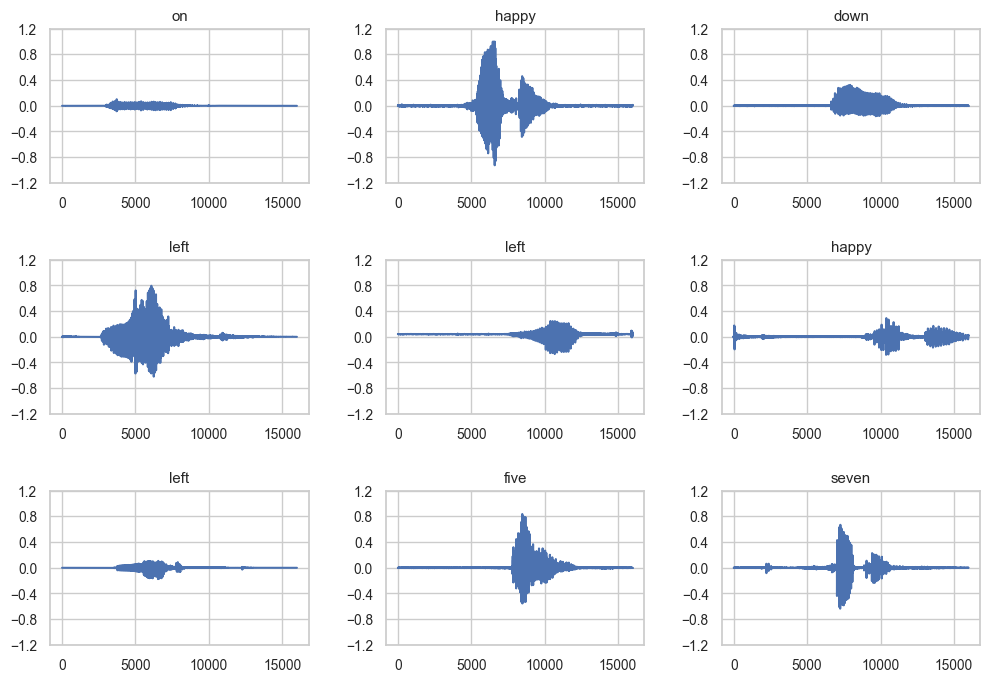

In [7]:
# modified code from https://www.tensorflow.org/tutorials/audio/simple_audio#import_the_mini_speech_commands_dataset
# sample observations
fig, axs = plt.subplots(3, 3, figsize=(12, 8))

for i, (example_audio, example_label) in enumerate(DS_TRAIN.take(9)):
    ax_idx = (i // 3, i % 3)
    axs[ax_idx].plot(example_audio)
    axs[ax_idx].set_title(CLASSES[example_label])
    axs[ax_idx].set_yticks(np.arange(-1.2, 1.21, 0.4))
    axs[ax_idx].set_ylim([-1.2, 1.2])

plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.savefig(f"images/sample_observations.png", bbox_inches="tight", dpi=300)
plt.show()

In [8]:
# re-labeling everything to the unknown class except the 10 base classes and the silence class
def relabel_map(audio, label):
    label = tf.where(label > 11, 11, label)
    return audio, label

DS_TRAIN = DS_TRAIN.map(relabel_map)
DS_VALID = DS_VALID.map(relabel_map)

#### Converting waveforms to spectrograms

In [9]:
# modified code from https://www.tensorflow.org/tutorials/audio/simple_audio#convert_waveforms_to_spectrograms
# frame_length and frame_step were chosen arbitrarily

def get_spectrogram(waveform):
  spectrogram = tf.signal.stft(waveform, frame_length=240, frame_step=120)
  spectrogram = tf.abs(spectrogram)
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

DS_TRAIN = DS_TRAIN.map(lambda audio, labels: (get_spectrogram(audio), labels), tf.data.AUTOTUNE)
DS_VALID = DS_VALID.map(lambda audio, labels: (get_spectrogram(audio), labels), tf.data.AUTOTUNE)
# DS_TEST = DS_TEST.map(lambda audio: get_spectrogram(audio, tf.data.AUTOTUNE)

In [10]:
# we end up with 132 x 129 x 1 vector
DS_TRAIN.element_spec

(TensorSpec(shape=(132, 129, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int32, name=None))

#### Counting labels

In [11]:
# counting labels
counts = collections.defaultdict(int)
for audio, label in DS_TRAIN:
    counts[label.numpy()] += 1
counts

defaultdict(int,
            {9: 1884,
             3: 1874,
             0: 1902,
             11: 32731,
             2: 1898,
             8: 1908,
             4: 1909,
             7: 1879,
             5: 1932,
             1: 1921,
             6: 1926,
             10: 332})

In [12]:
# because of the re-labeling process, there is too much obervations of the 'unknown' class
# randomly selected 90% of observations of the 'unknown' class will be dropped
# because we want to avoid problems with class imbalance

def predicate(audio, label):
    r = tf.random.uniform(shape=[], minval=0, maxval=1, seed=0)
    return label < 11 or (label == 11 and r < 0.1)

DS_TRAIN_U10 = DS_TRAIN.filter(predicate)
DS_VALID_U10 = DS_VALID.filter(predicate)

counts = collections.defaultdict(int)
for audio, label in DS_TRAIN_U10:
    counts[label.numpy()] += 1
counts

defaultdict(int,
            {11: 3327,
             6: 1926,
             3: 1874,
             7: 1879,
             2: 1898,
             5: 1932,
             8: 1908,
             1: 1921,
             0: 1902,
             9: 1884,
             4: 1909,
             10: 332})

In [13]:
DS_TRAIN = DS_TRAIN.batch(32, drop_remainder=True).cache().prefetch(tf.data.AUTOTUNE)
DS_VALID = DS_VALID.batch(32, drop_remainder=True).cache().prefetch(tf.data.AUTOTUNE)
DS_TRAIN_U10 = DS_TRAIN_U10.batch(32, drop_remainder=True).cache().prefetch(tf.data.AUTOTUNE)
DS_VALID_U10 = DS_VALID_U10.batch(32, drop_remainder=True).cache().prefetch(tf.data.AUTOTUNE)
# DS_TEST = DS_TEST.batch(32, drop_remainder=True).cache().prefetch(tf.data.AUTOTUNE)

#### Additional functions

In [14]:
# function that fits the model and returns the results

def fit_model(
    model,
    name="",
    callbacks=[],
    optimizer="adam",
    ds_train=DS_TRAIN,
    ds_valid=DS_VALID,
    epochs=EPOCHS,
    repetitions=REPETITIONS,
):
    results = []
    for i in range(repetitions):
        model = keras.models.clone_model(model)
        model.compile(
            optimizer=optimizer,
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"],
        )
        history = model.fit(ds_train, validation_data=ds_valid, epochs=epochs, callbacks=callbacks)
        frame = pd.DataFrame(history.history)
        frame["Name"] = name
        frame["Repetition"] = i
        frame = frame.reset_index().rename(columns={"index": "Epoch"})
        results.append(frame)
    return pd.concat(results)

In [15]:
# function that returns the lowest loss and the highest accuracy averaged over repetitions

def summary(results):
    tmp = (
        results.groupby(["Name", "Repetition"])
        .agg({"loss": "min", "accuracy": "max", "val_loss": "min", "val_accuracy": "max"})
        .groupby("Name")
    )
    mean = tmp.mean().round(3).applymap(lambda x: f"{x:.3f}")
    std = tmp.std().round(3).applymap(lambda x: f" ({x:.3f})")
    summary = mean + std
    return summary

In [16]:
# function that plots accuracy measure on validation set over epochs

def epoch_plot_accuracy(results, name, filename):
    tmp = (
        results.groupby([ "Name", "Epoch"])
        .agg({"val_accuracy": "mean"})
        .reset_index()
        .rename(columns={"Name": name})
    )
    fig, ax = plt.subplots(1, 1, figsize=(8, 3))
    sns.lineplot(data=tmp, x="Epoch", y="val_accuracy", hue=name, ax=ax)
    ax.set_ylim(0.0, 0.7)
    ax.set_xlim(-1, 30)
    ax.set_ylabel("Accuracy (validation set)")
    ax.set_xticks(ticks=[4, 9, 14, 19, 24, 29], labels=[5, 10, 15, 20, 25, 30])
    sns.move_legend(ax, "lower right")
    plt.savefig(f"images/{filename}", bbox_inches="tight", dpi=300)
    plt.show()

### Experiment 1.1 - network architectures

In [17]:
input_shape = (132, 129, 1)

In [ ]:
# Model - simple feed-forward neural network

model_simple = keras.models.Sequential()
model_simple.add(keras.Input(shape=input_shape))
model_simple.add(keras.layers.Resizing(32, 32))
model_simple.add(keras.layers.BatchNormalization())
model_simple.add(keras.layers.Flatten())
model_simple.add(keras.layers.Dense(32, activation='relu')) 
model_simple.add(keras.layers.Dropout(0.2))
model_simple.add(keras.layers.Dense(32, activation='relu')) 
model_simple.add(keras.layers.Dropout(0.2))
model_simple.add(keras.layers.Dense(32, activation='relu')) 
model_simple.add(keras.layers.Dropout(0.2))
model_simple.add(keras.layers.Dense(12, activation='softmax'))

results_simple = fit_model(model_simple, name="simple", ds_train=DS_TRAIN_U10, ds_valid=DS_VALID_U10)
results_simple.to_csv("results/experiment11_results_simple.csv", index=False)

In [ ]:
# Model - convolutional neural network

model_cnn = keras.models.Sequential()
model_cnn.add(keras.Input(shape=input_shape))
model_cnn.add(keras.layers.Resizing(32, 32))
model_cnn.add(keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model_cnn.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model_cnn.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model_cnn.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(keras.layers.BatchNormalization())
model_cnn.add(keras.layers.Flatten())
model_cnn.add(keras.layers.Dropout(0.2))
model_cnn.add(keras.layers.Dense(32, activation='relu')) 
model_cnn.add(keras.layers.Dense(12, activation='softmax'))

results_cnn = fit_model(model_cnn, name="CNN", ds_train=DS_TRAIN_U10, ds_valid=DS_VALID_U10)
results_cnn.to_csv("results/experiment11_results_cnn.csv", index=False)